In [1]:
import anacal
import galsim
import numpy as np
import matplotlib.pyplot as plt
import batsim
import astropy.io.fits as fits

from tqdm import tqdm, trange

from multiprocessing import Pool, cpu_count

In [7]:
print("g1-0".split("-"))

['g1', '0']


In [15]:
nstamp = 20  # nstamp x nstamp galaxies
print("Total number of galaxies: %d" % (nstamp * nstamp))
seed = 2  # seed for galaxy
noise_seed = 1  # seed for noise
pixel_scale = 0.2  # LSST image pixel scale
# noise variance for r-bands 10 year LSST coadd (magnitude zero point at 30)
noise_std = 0.37 #* np.sqrt(10)
noise_variance = noise_std ** 2.0
# NOTE: We can set noise variance to zero in the image simulation, but
# we cannot set that to zero in the measurement. The measurement needs a
# non-zero image noise variance to be run
# For the test with noiseless image simulation, we can set do_add_noise
# to False, but keep the noise variance to the realistic one as the input
# of the measurement
do_add_noise = True  # Add image noise or not
do_force_detect = True  # Force to have a detection at the center

rcut = 32  # cutout radius
test_component = 1  # which shear component to test
nrot_per_gal = 4  # number of rotation for each galaxy

# Simulation
ngrid = rcut * 2
if not do_force_detect:
    coords = None
    buff = 15
else:
    #
    # Force to have a detection at the center
    #
    indx = np.arange(ngrid // 2, ngrid * nstamp, ngrid)
    indy = np.arange(ngrid // 2, ngrid * nstamp, ngrid)
    ns = len(indx) * len(indy)
    inds = np.meshgrid(indy, indx, indexing="ij")
    yx = np.vstack([np.ravel(_) for _ in inds])
    buff = 0
    dtype = np.dtype(
        [
            ("y", np.int32),
            ("x", np.int32),
            ("is_peak", np.int32),
            ("mask_value", np.int32),
        ]
    )
    coords = np.empty(ns, dtype=dtype)
    coords["y"] = yx[0]
    coords["x"] = yx[1]
    coords["is_peak"] = np.ones(ns)
    coords["mask_value"] = np.zeros(ns)

fpfs_config = anacal.fpfs.FpfsConfig(
    sigma_arcsec=0.52,  # The first measurement scale (also for detection)
    sigma_arcsec2=0.8,  # The second measurement scale
)

psf_obj = galsim.Moffat(beta=3.5, fwhm=0.6, trunc=0.6 * 4.0)
psf_array = (
    psf_obj.shift(0.5 * pixel_scale, 0.5 * pixel_scale)
    .drawImage(nx=ngrid, ny=ngrid, scale=pixel_scale)
    .array
)

true_shear = 0.0007
print("True shear is %.6f" % true_shear)

# Measurement
out = []
for gname in ["g%d-1" % test_component, "g%d-0" % test_component]:
    gal_array = anacal.simulation.make_isolated_sim(
        gal_type="mixed",
        sim_method="fft",
        psf_obj=psf_obj,
        gname=gname,
        seed=seed,
        ny=ngrid * nstamp,
        nx=ngrid * nstamp,
        scale=pixel_scale,
        do_shift=False,
        buff=buff,
        nrot_per_gal=nrot_per_gal,
        mag_zero=30,
        shear_value=true_shear,
    )[0]

    if do_add_noise:
        # Add noise to galaxy image
        gal_array = gal_array + np.random.RandomState(noise_seed).normal(
            scale=noise_std,
            size=gal_array.shape,
        )
        # The pure noise for noise bias correction
        # make sure that the random seeds are different
        # (noise variance are the same)
        add_noise_seed = int(noise_seed + 1e6)
        noise_array = np.random.RandomState(add_noise_seed).normal(
            scale=noise_std,
            size=gal_array.shape,
        )
    else:
        noise_array = None
    out.append(
        anacal.fpfs.process_image(
            fpfs_config=fpfs_config,
            gal_array=gal_array,
            psf_array=psf_array,
            pixel_scale=pixel_scale,
            noise_variance=max(noise_variance, 0.23),
            noise_array=noise_array,
            coords=coords,
        )
    )

# Printing the results
print("Testing for shear component: %d" % test_component)
print("Measurement with sigma_arcsec=%.2f:" % fpfs_config.sigma_arcsec)
ename = "e%d" % test_component
egname = "e%d_g%d" % (test_component, test_component)
wgname = "w_g%d" % test_component
e1_0 = out[0]["w"] * out[0][ename]
e1_1 = out[1]["w"] * out[1][ename]
e1g1_0 = out[0][wgname] * out[0][ename] + out[0]["w"] * out[0][egname]
e1g1_1 = out[1][wgname] * out[1][ename] + out[1]["w"] * out[1][egname]

g1 = np.sum(e1_0) / np.sum(e1g1_0)
print("Measured shear is %.6f" % g1)
mbias = (np.sum(e1_0) - np.sum(e1_1)) / (
    np.sum(e1g1_0) + np.sum(e1g1_1)
) / true_shear - 1  # 0.02 is the input shear
print("    Multiplicative bias is %.3f e-3" % (mbias * 1e3))
cbias = (np.sum(e1_0) + np.sum(e1_1)) / (np.sum(e1g1_0) + np.sum(e1g1_1))
print("    Additive bias is %.3f e-5" % (cbias * 1e5))
#assert mbias < 2e-3

print("Measurement with sigma_arcsec=%.2f:" % fpfs_config.sigma_arcsec2)
ename = "e%d_2" % test_component
egname = "e%d_g%d_2" % (test_component, test_component)
e1_0 = out[0]["w"] * out[0][ename]
e1_1 = out[1]["w"] * out[1][ename]
e1g1_0 = out[0][wgname] * out[0][ename] + out[0]["w"] * out[0][egname]
e1g1_1 = out[1][wgname] * out[1][ename] + out[1]["w"] * out[1][egname]

g1 = np.sum(e1_0) / np.sum(e1g1_0)
print("Measured shear is %.6f" % g1)
mbias = (np.sum(e1_0) - np.sum(e1_1)) / (
    np.sum(e1g1_0) + np.sum(e1g1_1)
) / true_shear - 1  # 0.02 is the input shear
print("    Multiplicative bias is %.3f e-3" % (mbias * 1e3))
cbias = (np.sum(e1_0) + np.sum(e1_1)) / (np.sum(e1g1_0) + np.sum(e1g1_1))
print("    Additive bias is %.3f e-5" % (cbias * 1e5))
#assert mbias < 2e-3

Total number of galaxies: 400
True shear is 0.000700
Testing for shear component: 1
Measurement with sigma_arcsec=0.52:
Measured shear is -0.003280
    Multiplicative bias is -6.846 e-3
    Additive bias is -397.571 e-5
Measurement with sigma_arcsec=0.80:
Measured shear is -0.005834
    Multiplicative bias is 11.481 e-3
    Additive bias is -654.224 e-5


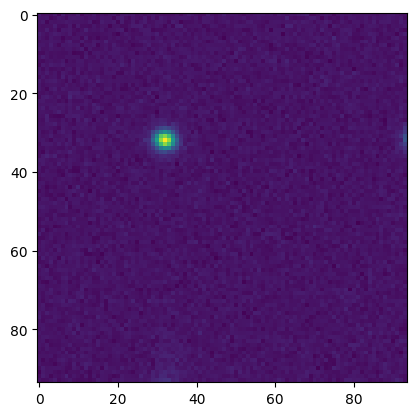

In [16]:
plt.imshow(gal_array[:94,:94])

In [142]:
with fits.open('simulations/isolated/COSMOS_ngals=100_noisy.fits') as hdul:
    # print headers
    print(hdul[-2].header['EXTNAME'])

NOISE_106423


100%|██████████| 100/100 [00:00<00:00, 855.03it/s]


(64, 64)


100%|██████████| 100/100 [00:00<00:00, 3162.27it/s]


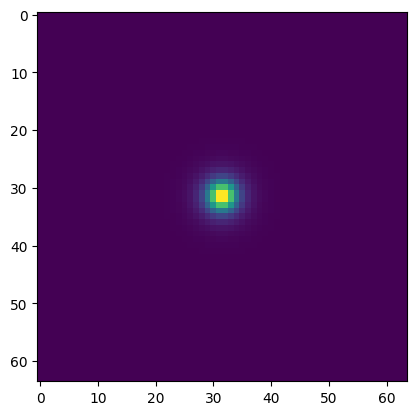

In [156]:
# Read in galaxy images with IA
filename = 'simulations/isolated/COSMOS_ngals=100_noisy.fits'

n_gals = 100
n_scenes = 1
gals_per_scene = n_gals // n_scenes

total_indices = np.arange(0,n_gals)
split_inds = np.array_split(total_indices, n_scenes)

cosmos = galsim.COSMOSCatalog()
records = cosmos.getParametricRecord(np.arange(len(cosmos)))

pad = 20
i = 0
ia_cosmos_list_noisy = []
hlrs = []
use_bulge = []
fluxes = []
records_inds = []
gal_ids = []
with fits.open(filename) as hdul:
    for j in tqdm(split_inds[i]):
        # exclude the first HDU
        data = hdul[j+1].data
        ia_cosmos_list_noisy.append(data)

        gal_id = hdul[j+1].header['IDENT']
        gal_ids.append(gal_id)

        record_ind = np.where(records['IDENT'] == gal_id)[0][0]
        records_inds.append(record_ind)
        
        bulge = records['use_bulgefit'][record_ind]
        use_bulge.append(bulge)
        if bulge:
            hlrs.append(records['hlr'][record_ind][2])
            fluxes.append(records['flux'][record_ind][3])
        else:
            hlrs.append(records['hlr'][record_ind][0])
            fluxes.append(records['flux'][record_ind][0])

    psf_array = hdul[-1].data
    # shrink psf
    #psf_array = psf_array[10:54,10:54]

print(psf_array.shape)
plt.imshow(psf_array)

# Read in galaxy images with IA
filename = 'simulations/isolated/COSMOS_ngals=100_noiseless.fits'

i = 0
ia_cosmos_list_noiseless = []
with fits.open(filename) as hdul:
    for j in tqdm(split_inds[i]):
        # exclude the first HDU
        data = hdul[j+1].data
        ia_cosmos_list_noiseless.append(data)

In [174]:
# now try inverse back into a list of single images
def split_image_into_quadrants(image, n_rot, nn):
    '''
    THIS CODE WILL SPLIT IMAGES OF 4 ROTATIONS INTO SINGLE
    IMAGES, EACH CONTAINING A SINGLE ROTATION. FOR SOME REASON
    THIS IS REQUIRED FOR THE BELOW METHOD OF MEASURING SHEAR.
    '''
    quadrants = []

    sqrt_n_rot = int(np.sqrt(n_rot))
    
    for j in range(n_rot):
        # Calculate the row and column positions
        row = j // sqrt_n_rot
        col = j % sqrt_n_rot

        # Calculate the bounds for this quadrant
        xmin = col * nn
        xmax = (col + 1) * nn
        ymin = row * nn
        ymax = (row + 1) * nn
        
        # Extract the quadrant
        quadrant = image[ymin:ymax, xmin:xmax]
        quadrants.append(quadrant)
    
    return quadrants

ia_cosmos_noisy_quadrants = []
ia_cosmos_noiseless_quadrants = []
for i in range(len(ia_cosmos_list_noisy)):
    quadrants_noisy = split_image_into_quadrants(ia_cosmos_list_noisy[i], nrot_per_gal, ngrid)
    ia_cosmos_noisy_quadrants.extend(quadrants_noisy)

    quadrants_noiseless = split_image_into_quadrants(ia_cosmos_list_noiseless[i], nrot_per_gal, ngrid)
    ia_cosmos_noiseless_quadrants.extend(quadrants_noiseless)

# Stacka all quadrants into a single square image
n = int(np.sqrt(len(ia_cosmos_noisy_quadrants)))
nn = ngrid
noisy_stacked = np.zeros((n*nn,n*nn))
noiseless_stacked = np.zeros((n*nn,n*nn))

for i in range(n):
    for j in range(n):
        noisy_stacked[i*nn:(i+1)*nn,j*nn:(j+1)*nn] = ia_cosmos_noisy_quadrants[i*n+j]
        noiseless_stacked[i*nn:(i+1)*nn,j*nn:(j+1)*nn] = ia_cosmos_noiseless_quadrants[i*n+j]

# Pad the stacked images
noisy_stacked = np.pad(noisy_stacked, pad_width=buff, mode='constant', constant_values=0)
noiseless_stacked = np.pad(noiseless_stacked, pad_width=buff, mode='constant', constant_values=0)

# add_noise_seed = int(1337 + 1e8)
# noise_array = np.random.RandomState(add_noise_seed).normal(
#     scale=noise_std,
#     size=noisy_stacked.shape,
# )

print(noiseless_stacked.shape)

(1310, 1310)


In [175]:
# Measurement
out = []
for gname in ["g%d-1" % test_component, "g%d-0" % test_component]:
    out.append(
        anacal.fpfs.process_image(
            fpfs_config=fpfs_config,
            gal_array=noisy_stacked,
            psf_array=psf_array,
            pixel_scale=pixel_scale,
            noise_variance=max(noise_variance, 0.23),
            noise_array=noise_array,
            coords=None,
        )
    )

# Printing the results
print("Testing for shear component: %d" % test_component)
print("Measurement with sigma_arcsec=%.2f:" % fpfs_config.sigma_arcsec)
ename = "e%d" % test_component
egname = "e%d_g%d" % (test_component, test_component)
wgname = "w_g%d" % test_component
e1_0 = out[0]["w"] * out[0][ename]
e1_1 = out[1]["w"] * out[1][ename]
e1g1_0 = out[0][wgname] * out[0][ename] + out[0]["w"] * out[0][egname]
e1g1_1 = out[1][wgname] * out[1][ename] + out[1]["w"] * out[1][egname]

# mbias = (np.sum(e1_0) - np.sum(e1_1)) / (
#     np.sum(e1g1_0) + np.sum(e1g1_1)
# ) / 0.02 - 1  # 0.02 is the input shear
# print("    Multiplicative bias is %.3f e-3" % (mbias * 1e3))
# cbias = (np.sum(e1_0) + np.sum(e1_1)) / (np.sum(e1g1_0) + np.sum(e1g1_1))
# print("    Additive bias is %.3f e-5" % (cbias * 1e5))
# #assert mbias < 2e-3
print("    Measured shear is %.3f" % (np.sum(e1_0) + np.sum(e1_1)))

print("Measurement with sigma_arcsec=%.2f:" % fpfs_config.sigma_arcsec2)
ename = "e%d_2" % test_component
egname = "e%d_g%d_2" % (test_component, test_component)
e1_0 = out[0]["w"] * out[0][ename]
e1_1 = out[1]["w"] * out[1][ename]
e1g1_0 = out[0][wgname] * out[0][ename] + out[0]["w"] * out[0][egname]
e1g1_1 = out[1][wgname] * out[1][ename] + out[1]["w"] * out[1][egname]

# mbias = (np.sum(e1_0) - np.sum(e1_1)) / (
#     np.sum(e1g1_0) + np.sum(e1g1_1)
# ) / 0.02 - 1  # 0.02 is the input shear
# print("    Multiplicative bias is %.3f e-3" % (mbias * 1e3))
# cbias = (np.sum(e1_0) + np.sum(e1_1)) / (np.sum(e1g1_0) + np.sum(e1g1_1))
# print("    Additive bias is %.3f e-5" % (cbias * 1e5))
#assert mbias < 2e-3
print("    Measured shear is %.3f" % (np.sum(e1_0) + np.sum(e1_1)))

Testing for shear component: 1
Measurement with sigma_arcsec=1.00:
    Measured shear is 0.691
Measurement with sigma_arcsec=0.45:
    Measured shear is -0.213
